# Project: Continuous_Control

## Set Unity Environment

Before run the code, you need to download and locate **"Reacher Unity Environment"** in the same folder as the [Cintinuous_Control.ipynb](https://github.com/jhyun0919/udacity_drlnd_p2/blob/master/Continuous_Control.ipynb) file.

---

## Build Network Model & Agent

- To solve the given environment, I build codes for agent and DDPG model.  
- To do this, I referred to some of [the materials](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) in Udacity DRLND's class.

### Code for Agent

```python
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, num_agents=1):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            num_agents (int): number of agents
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), 
                                           lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        
```

- **Actor** has a **local** and a **target** network of the **same structure**.  
- **Critic** has a **local** and a **target** network of the **same structure**.  
 
 
- The structures of the networks used in Actors and Critic was defined in the **DDPG Model**.

```python
     def step(self, state, action, reward, next_state, done, time_step):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        # Learn every UPDATE_EVERY time steps.
        if len(self.memory) > BATCH_SIZE and time_step % UPDATE_EVERY == 0:
            for _ in range(UPDATE_NUM):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
```

- The agent used in the Navigation project **_learn after storing enough experience_**.  
- This **idea** has been implemented into this part.


- The result was not good if the agents do **learn once** after collecting enough experience in the Replay-memory.
- I modified it by **executing multiple learns** after collecting enough experience.


```python
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.epsilon * self.noise.sample()
        return np.clip(action, -1, 1)

```

---

### Code for DDPG Model

```python
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed=0, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
#         x = self.bn1(F.relu(self.fc1(state)))
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed=0, fcs1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)     
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
#         xs = self.bn1(F.relu(self.fcs1(state)))
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)
```

#### Actor
- The Actor network consists of **three fully-connected layers** and a **ReLU**, and the **tanh function** is implemented at the last output to assign the **contiguous action value**.

#### Critic
- In the Critical network, **three fully-connected layers** and **leaky ReLU** were implemented. 
- The first fully-connected layer get the state value as input features.
- The second fully-connected layer get the output of the first layer and action value as  features.

#### Batch-Normalization
- To **speed up** and **stabilize** the training, I implemented a **Batch-Normalization layer** behind the first layer of Actor Network and Critic Network. 
- To decide where to add BN layer, I refer to following references:
    - [[reddit_discussion] Batch Normalization before or after ReLU?](https://www.reddit.com/r/MachineLearning/comments/67gonq/d_batch_normalization_before_or_after_relu/)
    - [Evaluation of BN performance on ImageNet-2012](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md)

```python
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)
```

#### Weight initialization
- Actor and Critic initialize weights in the range of $[-y, y]$ where $y=1/\sqrt{n}$  
($n$ is the number of inputs to a given neuron).

---

## Train the Agent

#### Wrong answer

```python
    # start training
    for i_episode in range(1, n_episodes + 1):
        # reset environment information
        states = env_info.vector_observations

        # reset all agents
        for agent in agents:
            agent.reset()

        # roll over
        for t in range(max_time_step):
            # choose an action for each agent
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]
            
            # update env
            updated_env_info = env.step(actions)[brain_name]
            
            # update next_states
            next_states = updated_env_info.vector_observations
            
            # update rewards
            rewards = updated_env_info.rewards
            
            # check the episode is fininshed for each agent
            dones = updated_env_info.local_done
            
            # step: save experience in replay memory, and use random sample from buffer to learn
            ## use zip function for multiple agents (option 2.)
            if is_train:
                step_t = zip(agents, states, actions, rewards, next_states, dones)
                for agent, state, action, reward, next_step, done in step_t:
                    agent.step(state, action, reward, next_step, done, t)
                    
            # update currunts state as nest_states
            states = next_states
            # update scores
            scores += rewards
            
            # break if any episode is finished
            if np.any(dones):
                break
```

#### Feedback from Udacity's Reviewer

- All the required files were submitted. However, it appears you have an **error** in your code. To get an accurate estimate of your agent's performance, you must **reset the score to zero at the beginning of each episode**. ...

#### Correct answer

```python
# start training
    for i_episode in range(1, n_episodes + 1):
        # reset scores for each agents
        scores = np.zeros(num_agents)

        # reset environment information
        env_info = env.reset(train_mode=is_train)[brain_name]
        states = env_info.vector_observations

        # reset all agents
        for agent in agents:
            agent.reset()

        # roll over
        for t in range(max_time_step):
            # choose an action for each agent
            actions = [agent.act(states[i], add_noise=True) for i, agent in enumerate(agents)]

            # update env
            updated_env_info = env.step(actions)[brain_name]

            # update next_states
            next_states = updated_env_info.vector_observations

            # update rewards
            rewards = updated_env_info.rewards

            # check the episode is fininshed for each agent
            dones = updated_env_info.local_done

            # step: save experience in replay memory, and use random sample from buffer to learn
            # use zip function for multiple agents (option 2.)
            if is_train:
                step_t = zip(agents, states, actions,
                             rewards, next_states, dones)
                for agent, state, action, reward, next_step, done in step_t:
                    agent.step(state, action, reward, next_step, done, t)

            # update currunts state as nest_states
            states = next_states
            # update scores
            scores += rewards

            # break if any episode is finished
            if np.any(dones):
                break
```

---

## Plot the Result

In [2]:
from IPython.display import Image

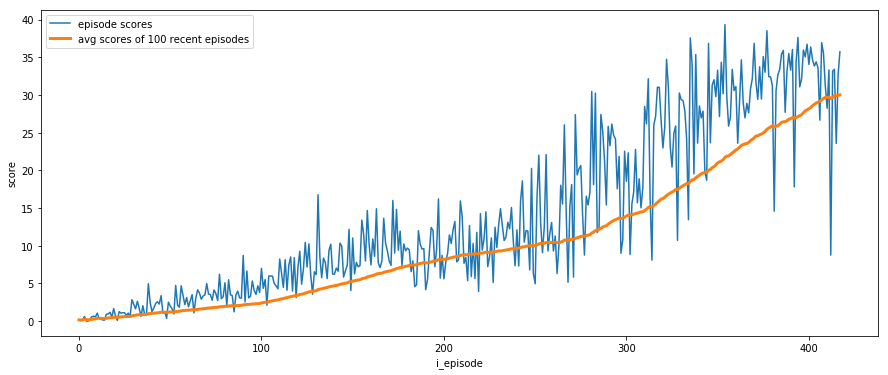

In [7]:
Image(filename='./result_plot.png')

---

## Idea for Future Work

To improve the agent's performance, we can try the following:

1. Do more **fine tuning** through changing the hyper-parameters. 


2. Try adding [Reward-Clipping](https://medium.com/deep-math-machine-learning-ai/ch-13-deep-reinforcement-learning-deep-q-learning-and-policy-gradients-towards-agi-a2a0b611617e).


3. Use other activation functions.  

    * e.g. [GELU](https://arxiv.org/abs/1606.08415) 